<a href="https://colab.research.google.com/github/GamaLab42/Material_EQE_441/blob/main/Equa%C3%A7%C3%B5es_de_Momento_e_Cin%C3%A9tica_de_Cristaliza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas


In [1]:
# Bibliotecas usadas nas equações
import numpy as np  # Permite o uso de uma ampla variedades de operações matemáticas
import mpmath       # Para resolver o sistema de eq. diferenciais, nós utilizados a
                    #  DASSL. Devido o algorítimo utilizado ter base na linguagem C++,
                    #  ocorre um bug quando temos termos exponenciais não-inteiros.
                    #  Exemplo: 2^0.5 roda, mas 2^0.584 não.
                    #  Esse pacote permite contornar esse bug.

# Biliotecas usadas para plotar as figuras
import matplotlib.pyplot as plt                           # Permite a geração de figuras de forma similar ao MATLAB
import matplotlib.ticker as mticker                       # Essa biblioteca auxilia na formatação das figuras

from ipywidgets import interact, interactive              # Função utilizada para permitir que a figura seja interativa
from IPython.display import clear_output, display, HTML   # Função auxiliar do método interativo da figura

# Biliotecas usadas para cálcular o tempo de compilação
import time


Instalação do pacote para usar o "Differential-Algebraic System Solver in C" desenvolvido pelo prof. Argimiro R. Secchi (PEQ/COPPE/UFRJ) em Python usando o Cython (que permite escrever códigos em python declarando funções, tipos, classes e variáveis em C).

Esse código foi inicialmente desenvolvido pelo PhD Caio Curitiba Marcellos. Hoje, a atualização do código é realizada pelo PhD Iuri Segtovich
(https://github.com/iurisegtovich/dasslcy).


In [2]:
!git clone https://github.com/iurisegtovich/dasslcy.git

Cloning into 'dasslcy'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 250 (delta 3), reused 11 (delta 2), pack-reused 232 (from 1)
Receiving objects: 100% (250/250), 844.62 KiB | 5.00 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [3]:
%%bash
cd dasslcy
pip install .

Processing /content/dasslcy
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dasslcy: filename=dasslcy-0.1-cp310-cp310-linux_x86_64.whl size=565799 sha256=b23fa55fae63b14661d2bb49052c71369573415a724928695c552474db3e50bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-e26_nqtd/wheels/79/2f/53/98b2cb35d6ede3587e35e2ede2cb4bdc3f84cf97fdbd9c3bb2
Successfully built dasslcy


In [4]:
# Após a instalação, a biblioteca "dasslcy" precisa ser importada para ser corretamente utilizada
#   OBS: No PC, a instalação realizada acima só precisa ser feita uma única vez. No colab, é
#         necessário a instalação todas as vezes que é iniciado o ambiente de execução.

import dasslcy


## Parâmetros utilizados no modelo

Os parâmetros apresentados aqui foram estimados para um estudo de caso da formação de cristais de $K_2SO_4$. Para mais informações, recomenda-se a leitura do artigo do prof. Marcellus de Moraes (2023):

"*Modeling and Predictive Control of Cooling Crystallization of Potassium Sulfate by Dynamic Image Analysis: Exploring Phenomenological and Machine Learning Approaches*"

DOI: https://doi.org/10.1021/acs.iecr.3c00739

In [31]:
## Iniciar as constantes utilizadas no modelo

# @title Parâmetros do sistema: { display-mode: "form", run: "auto" }

# @markdown Tempo (min)
Tempo         = 70      # @param {type:"number"}    # mim
Tempo = float(Tempo)

# @markdown Temperatura (K)
T         = 273.15+39.38      # @param {type:"number"}    # Kelvin

EQ        = 5                 # Número de Equações

# @markdown Energia de ativação do crecimento ($E_{Ag}$, J/mol/R)
E_Ag      = 4.8654E+3          # @param {type:"number"}    # Growth activation energy

# @markdown Energia de ativação da nucleação ($E_{Ab}$, J/mol/R)
E_Ab      = 6.8740E+3          # @param {type:"number"}    # Nucleation activation energy

# @markdown Parâmetro adimensional do termo de nucleação [-]
b         = 0.8361                 # @param {type:"number"}    # Nucleation supersaturation exponent

# @markdown Parâmetro adimensional do termo de nucleação ($\beta$, [-])

beta      = 1.3728                 # @param {type:"number"}    # Nucleation rate

# @markdown Parâmetro adimensional do termo de crescimento [-]
g         = 1.6228                 # @param {type:"number"}    # Growth exponent parameter

# @markdown Constante da taxa de crescimento [$k_g$, $(\mu m/min)(L/g)^g$)

kg        = 3.7792E+5                 # @param {type:"number"}    # Growth rate constant

# @markdown Constante da nucleação ($k_b$, $\left[\left(min \cdot cm^3\right)^{-1}\left(L\text{ de solução}/g\right)^b\left(cm^3\text{ da suspensão}/\mu m^3\right)^{\beta}\right]$)

kb        = 0.9341                # @param {type:"number"}    # Nucleation constant

# @markdown Fator de forma de volume ($k_V$, [-])

kv        = 1.3486                 # @param {type:"number"}    # Volume shape factor

# @markdown Constante de crescimento dependente do tamanho ($\gamma$, $1/\mu m $)

gamma     = 2.3895E-3                 # @param {type:"number"}    # Size-dependent growth constant

# @markdown Densidade do cristal ($\rho_c$, $g/\mu m^3$) - Estudo de caso $K_2SO_4$

ro        = 2.36E-12                 # @param {type:"number"}    # 2.36 g/cm^3 K2SO4


## Modelo de cinética de precipitação e cristalização

As equações apresentadas aqui estão de acordo com Moraes et al (2023): https://doi.org/10.1021/acs.iecr.3c00739

O balanço de massa do soluto no cristalizador em batelada é expresso por:

$\dfrac{dC}{dt} = - \dfrac{3 \ \rho_c k_V }{1 - \vartheta} \ G_0 \ (\mu_{2} + \gamma \ \mu_{3})$

em que $C$ é a concentração ($g$ de soluto/$L$ de solução), $\rho_c$ é a densidade do cristal, $\gamma$ é a constante de crescimento dependente do tamanho $\left( 1/\mu m \right)$; $\vartheta$ é a fração volumétrica da população total de cristais, definido por:

$\vartheta = k_V \ \mu_3 \cdot 10^{-12}$ \
em que $k_V$ é o fator de forma. O termo $10^{-12}$ converte o terceiro momento ($\mu_3$, $\mu m^3 / cm^3$ de suspensão) para um fator adimensional.

In [6]:
def func_C(ro, kv, G0, mu2, mu3, gamma):
    tetha = kv*mu3*1.0e-12
    return 3.*ro*kv*G0*(mu2 + gamma*mu3)/(1.-tetha)

$G_0$ [$\mu m /min$] está relacionado com a taxa de crescimento dependente do tamanho, sendo $G_0$ um fator dependente da temperatura e da supersaturação:

$G_0 = k_g \exp\left(\dfrac{-E_{Ag}}{RT}\right)\Delta C^g $

em que $k_g$ é a constante da taxa de crescimento [$(\mu m/min)(L/g)^g$, com o expoente $g$ sendo um parâmetro adimensional relacionado com a taxa]; $-E_{Ag}$ é a energia de ativação do crecimento $\left(J/mol\right)$; $R$ e $T$ são a constante universal dos gases e a temperatura do sistema ($K$), respectivamente; A supersaturação absoluta é $\Delta C = C - C_s$ ($g$/$L$ de solução), com $C_s$ representando a concentração de soluto no equilíbrio.

In [7]:
def func_G0(E_Ag, T, C, g, kg):
    dC = C/1000 - func_Cs(T)
    return kg*np.exp(-E_Ag/T)*round(float(mpmath.re(mpmath.power(dC, g))), 10)

Uma correlação dependente da temperatura para $C_s$ ($g$/$L$ de solução)
foi obtida a partir de dados experimentais de solubilidade de $K_2SO_4$ em água (faixa entre 0 a 100 ºC):

$C_s(T)[g/L] = -687.27 + 3.5795T - 2.9287 \cdot 10^{-3}T^2$

In [8]:
def func_Cs(T):
    return (-687.27 + 3.5795*(T) - 2.9287E-3*(T)**2)

A condição de contorno estabelece que a taxa de nucleação $[(min \cdot cm^{3})^{-1}]$ é descrita por:

$B = k_b \exp\left(\dfrac{-E_{Ab}}{RT}\right)\Delta C^b \mu_3^{\beta} $

em que $k_b$ é a constante da nucleação, em unidades de $\left[\left(min \cdot cm^3\right)^{-1}\left(L\text{ de solução}/g\right)^b\left(cm^3\text{ da suspensão}/\mu m^3\right)^{\beta}\right]$; $E_{Ab}$ é a energia de ativação da nucleação $\left(J/mol\right)$; e $b$ e $\beta$ são expoentes adimensionais.

In [9]:
def func_B(E_Ab, T, C, b, mu3, kb):
    dC = C/1000 - func_Cs(T)
    return kb*np.exp(-E_Ab/T)*round(float(mpmath.re(mpmath.power(dC, b))), 10)*round(float(mpmath.re(mpmath.power(mu3, beta))), 10)












Para encontrar o valor de $B$ e resolver o balanço de massa, são necessários determinar os momentos $\mu_0$, $\mu_1$, $\mu_2$ e $\mu_3$. Esses parâmetros estão relacionados, respectivamente, ao número, comprimento, área superficial e volume total de cristais:

$\dfrac{d\mu_{0}}{dt} = B$ \
$\dfrac{d\mu_{1}}{dt} = G_0 (\mu_0 +  \gamma \ \mu_1)$ \
$\dfrac{d\mu_{2}}{dt} = 2 \ G_0 (\mu_1 +  \gamma \ \mu_2)$ \
$\dfrac{d\mu_{3}}{dt} = 3 \ G_0 (\mu_2 +  \gamma \ \mu_3)$



In [10]:
def func_mu1(G0, mu0, mu1):
    return G0*(mu0 + gamma*mu1)
def func_mu2(G0, mu1, mu2):
    return 2.*G0*(mu1 + gamma*mu2)
def func_mu3(G0, mu2, mu3):
    return 3.*G0*(mu2 + gamma*mu3)

## Resolvendo o sistema de derivadas utilizando a DASSL

In [11]:
def model(t,y,yp,par):
  E_Ag, E_Ab, kg, kb = par
  res = np.zeros((EQ,))

  mu0 = y[0]
  mu1 = y[1]
  mu2 = y[2]
  mu3 = y[3]
  C   = y[4]
  mu0_PRIME   = yp[0]
  mu1_PRIME   = yp[1]
  mu2_PRIME   = yp[2]
  mu3_PRIME   = yp[3]
  C_PRIME     = yp[4]

  Cs = (-687.27 + 3.5795*(T) - 2.9287E-3*(T)**2)
  dC    = C*1000 - Cs

  G0 = kg*np.exp(-E_Ag/T)*round(float(mpmath.re(mpmath.power(dC, g))), 10)
  B  = kb*np.exp(-E_Ab/T)*round(float(mpmath.re(mpmath.power(dC, b))), 10)*round(float(mpmath.re(mpmath.power(mu3, beta))), 10)

  tetha = kv*mu3*1.0e-12

  res[0]  =  mu0_PRIME - B
  res[1]  =  mu1_PRIME - G0*(mu0 + gamma*mu1)
  res[2]  =  mu2_PRIME - 2.*G0*(mu1 + gamma*mu2)
  res[3]  =  mu3_PRIME - 3.*G0*(mu2 + gamma*mu3)
  res[4]  =  - C_PRIME - 3.*ro*kv*G0*(mu2 + gamma*mu3)/(1.-tetha)
  ires = 0

  return res, ires

In [12]:
# @title Condições iniciais (Moraes et al 2023): { display-mode: "form", run: "auto" }

# @markdown $\mu_0$ ($1/cm^3$)
mu0_0         = 1559.23        # @param {type:"number"}

# @markdown $\mu_1$ ($\mu m/cm^3$)
mu1_0         = 21_237.53      # @param {type:"number"}

# @markdown $\mu_2$ ($\mu^2 m/cm^3$)
mu2_0         = 1_847_000.97   # @param {type:"number"}

# @markdown $\mu_3$ ($\mu^3 m/cm^3$)
mu3_0         = 234_067_271.73 # @param {type:"number"}

# @markdown $C_0$ ($g/cm^3$)
C0            = 0.1605         # @param {type:"number"}

In [55]:
# @title Código para geração dos gráficos { display-mode: "form", run: "auto" }

def plot_fig(t,y,time):
  fig, axs = plt.subplots(2, 3, figsize=(13, 8))

  # Plotando os dados no subplot [0, 0]
  axs[0, 0].plot(t, y[:, 0])
  #axs[0, 0].set_ylim([0, 4E+5])
  axs[0, 0].set_xlim([0, time])
  axs[0, 0].set_ylabel('$\mu_0$ ($1/cm^3$)')
  axs[0, 0].set_xlabel('Tempo (min)')
  axs[0, 0].set_xticks(range(0, int(time), int(time/10)))

  # Forçar notação científica no y-axis do subplot [0, 0]
  axs[0, 0].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
  axs[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

  # Plotando os dados no subplot [0, 1]
  axs[0, 1].plot(t, y[:, 1], 'tab:orange')
  #axs[0, 1].set_ylim([0, 4E+6])
  axs[0, 1].set_xlim([0, time])
  axs[0, 1].set_ylabel('$\mu_1$ ($\mu m/cm^3$)')
  axs[0, 1].set_xlabel('Tempo (min)')
  axs[0, 0].set_xticks(range(0, int(time), int(time/10)))

  # Forçar notação científica no y-axis do subplot [0, 1]
  axs[0, 1].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
  axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

  # Plotando os dados no subplot [0, 2]
  axs[0, 2].plot(t, y[:, 2], 'tab:green')
  #axs[0, 2].set_ylim([0, 1E+8])
  axs[0, 2].set_xlim([0, time])
  axs[0, 2].set_ylabel('$\mu_2$ ($\mu m^2/cm^3$)')
  axs[0, 2].set_xlabel('Tempo (min)')
  axs[0, 0].set_xticks(range(0, int(time), int(time/10)))

  # Forçar notação científica no y-axis do subplot [0, 2]
  axs[0, 2].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
  axs[0, 2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

  # Plotando os dados no subplot [1, 0]
  axs[1, 0].plot(t, y[:, 3], 'tab:red')
  #axs[1, 0].set_ylim([0, 6E+9])
  axs[1, 0].set_xlim([0, time])
  axs[1, 0].set_ylabel('$\mu_3$ ($\mu m^3/cm^3$)')
  axs[1, 0].set_xlabel('Tempo (min)')
  axs[0, 0].set_xticks(range(0, int(time), int(time/10)))

  # Forçar notação científica no y-axis do subplot [1, 0]
  axs[1, 0].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
  axs[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

  # Adicionando a quinta figura no subplot [1, 1]
  axs[1, 1].plot(t, y[:, 4], 'tab:purple')
  #axs[1, 1].set_ylim([0.14, 0.17])
  axs[1, 1].set_xlim([0, time])
  axs[1, 1].set_ylabel('$C_0$ ($g/cm^3$)')
  axs[1, 1].set_xlabel('Tempo (min)')
  axs[0, 0].set_xticks(range(0, int(time), int(time/10)))

  # Forçar notação científica no y-axis do subplot [1, 1]
  axs[1, 1].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
  axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

  # Deixando o último subplot vazio
  axs[1, 2].axis('off')  # Desliga o último eixo.
                         #   Estamos trabalhando com um nº impar de figuras

  plt.tight_layout()     # Evitar sobreposições das figuras

  return plt.show()

In [56]:
def solve_cristalization(E_Ag = 4.8654E+3 , E_Ab = 6.8740E+3, kg = 3.7792E+5, kb = 0.9341, Tempo = Tempo):
    atol = 1e-8 # Tolerância absoluta
    rtol = 1e-6 # Tolerância relativa

    par = (
        E_Ag, E_Ab, kg, kb
    )

    # Tempo total do processo de cinética
    t0 = np.array([Tempo], dtype=np.float64)

    # Iniciando os vetores das condições iniciais
    y0 = np.zeros(EQ, dtype=np.float64)
    yp0 = np.zeros(EQ, dtype=np.float64)

    # Repassando os valores iniciais estabelecidos
    y0[0] = mu0_0
    y0[1] = mu1_0
    y0[2] = mu2_0
    y0[3] = mu3_0
    y0[4] = C0

    # Resolvendo o sistema
    t_, y, yp = dasslcy.solve(model,t0,y0,yp0,par,rtol,atol)
    t=np.asarray(t_)

    plot_fig(t,y,Tempo)

    return t, y

In [40]:
print(f"Perfil dos momentos e da concentração em batelada a temperatura constante {T} K.")


Perfil dos momentos e da concentração em batelada a temperatura constante 312.53 K.


In [60]:
w = interactive(solve_cristalization, E_Ag=(6.0E+2,7.0E+3), E_Ab=(7.0E+2,9.0E+3),
                kg = (3.0E+5, 5.0E+5), kb=(0.0,1.0), Tempo=(40.,10*Tempo))
display(w)

interactive(children=(FloatSlider(value=4865.4, description='E_Ag', max=7000.0, min=600.0), FloatSlider(value=…

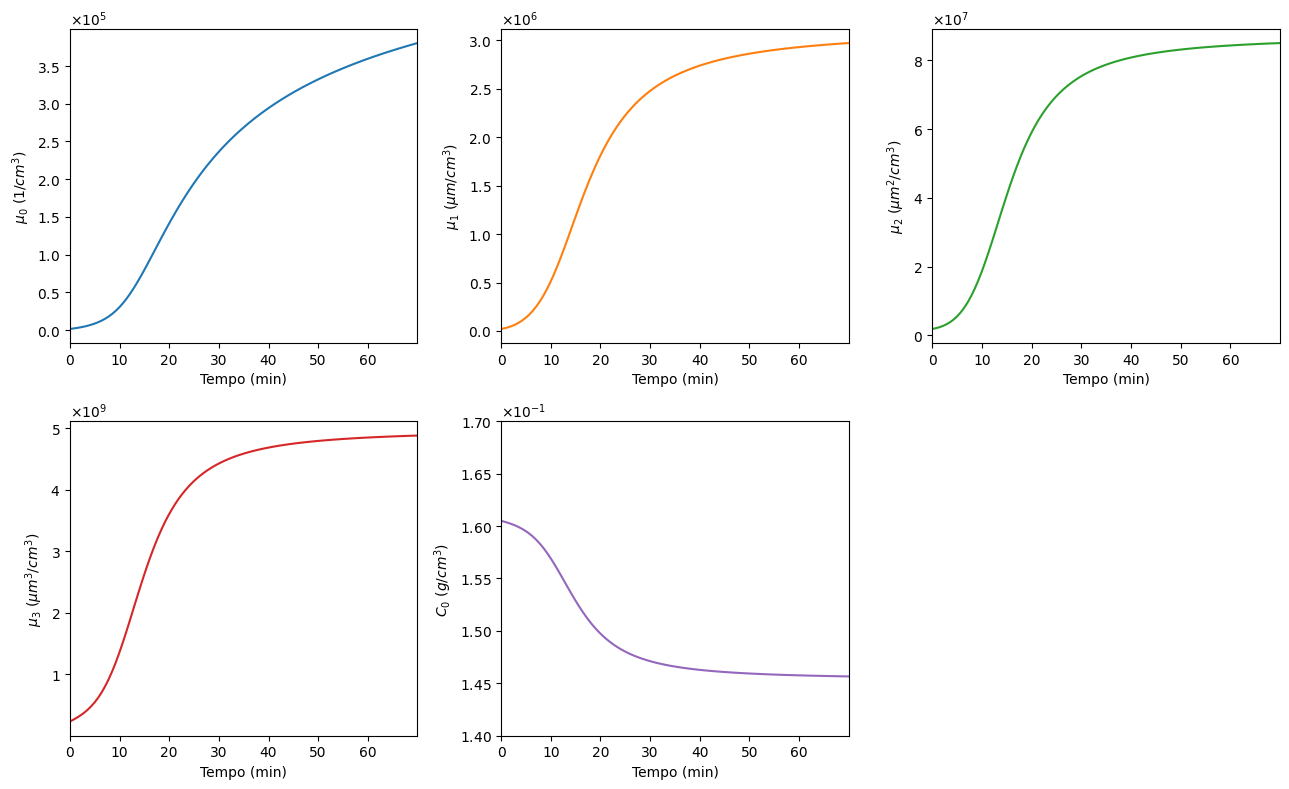

In [45]:
# @title Plot estático das figuras { display-mode: "form", run: "auto" }

atol = 1e-8
rtol = 1e-6

par = (
        E_Ag, E_Ab, kg, kb
    )

t0 = np.array([Tempo], dtype=np.float64)

y0 = np.zeros(EQ, dtype=np.float64)
yp0 = np.zeros(EQ, dtype=np.float64)

y0[0] = mu0_0
y0[1] = mu1_0
y0[2] = mu2_0
y0[3] = mu3_0
y0[4] = C0

t_, y, yp = dasslcy.solve(model,t0,y0,yp0,par,rtol,atol)
t=np.asarray(t_)

plot_fig(t,y,Tempo)